**Aluna**: BEATRIZ EMILY SILVA AGUIAR

**matrícula**: 22154303

**LINK REPOSITORIO:** https://github.com/Nibi2003/Processamento-Digital-de-Imagens/tree/main

In [1]:
!pip install torch torchvision torchaudio
!pip install opencv-python tqdm einops
!pip install ffmpeg-python
!pip install -q gdown

#Baixar nossos dados

In [ ]:
folder_id = "1C2awOPCmnDNOVqeeWYvNt_3-qfcTKAhi"

!gdown --folder https://drive.google.com/drive/folders/1C2awOPCmnDNOVqeeWYvNt_3-qfcTKAhi --remaining-ok -O /content/dataset


# Dataloader

In [11]:
import os
import cv2
import numpy as np
import random
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc
import pandas as pd

def get_category(filename: str) -> str:
    """Detecta a categoria com base no nome do arquivo."""
    name = filename.lower()
    if "desenho" in name:
        return "Desenho"
    elif "filme" in name:
        return "Filme"
    elif "musica" in name or "official" in name:
        return "Musica"
    else:
        return "Others"


class VideoDataLoader:
    """
    Carrega vídeos sob demanda com suporte a rótulos manuais (.txt).
    Agora os arquivos .txt são detectados mesmo que não tenham nome idêntico ao .mp4,
    apenas contendo parte do nome (ex: 'Anya.txt' → 'Anya_Desenho.mp4').
    """

    def __init__(self, root_path: str, max_frames: int = 100):
        self.root_path = root_path
        self.video_files = [
            os.path.join(root_path, f)
            for f in os.listdir(root_path)
            if f.lower().endswith((".mp4", ".avi", ".mov", ".mkv"))
        ]
        self.txt_files = [
            os.path.join(root_path, f)
            for f in os.listdir(root_path)
            if f.lower().endswith(".txt")
        ]
        self.index = 0
        self.max_frames = max_frames

    def __len__(self):
        return len(self.video_files)

    def reset(self):
        """Reinicia o índice"""
        self.index = 0

    def next(self):
        """Carrega o próximo vídeo, pré-processa e retorna os dados."""
        if self.index >= len(self.video_files):
            print(" Todos os vídeos foram processados.")
            return {
                "video_name": None,
                "video_path": None,
                "category": None,
                "fps": 0,
                "total_frames": 0,
                "sampled_indices": [],
                "frames": [],
                "labels": [],
            }

        video_path = self.video_files[self.index]
        self.index += 1

        data = self._load_and_process(video_path)
        gc.collect()
        return data

    def _find_label_file(self, video_name: str):
        """
        Procura um arquivo .txt de rótulos cujo nome esteja contido
        no nome do vídeo (ou vice-versa).
        """
        base_name = os.path.splitext(video_name)[0].lower()
        for txt_path in self.txt_files:
            txt_name = os.path.basename(txt_path).lower().replace(".txt", "")
            if txt_name in base_name or base_name in txt_name:
                return txt_path
        return None

    def _load_and_process(self, video_path: str):
        """Lê vídeo, aplica skip-frame (~1s) e retorna frames + rótulos."""
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"[ERRO] Não foi possível abrir o vídeo: {video_path}")
            return self._empty_result(video_path)

        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = max(1, int(round(fps)))  # ~1 frame por segundo

        frames, indices = [], []
        for i in tqdm(range(0, total_frames, step), desc=os.path.basename(video_path)):
            if len(frames) >= self.max_frames:
                break

            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                break
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
            indices.append(i)

        cap.release()

        # === Detecta arquivo de rótulo correspondente ===
        label_path = self._find_label_file(os.path.basename(video_path))
        labels = self._load_labels(label_path) if label_path else []

        result = {
            "video_name": os.path.basename(video_path),
            "video_path": video_path,
            "category": get_category(video_path),
            "fps": fps,
            "total_frames": total_frames,
            "sampled_indices": indices,
            "frames": frames,
            "labels": labels,
        }

        del cap, frame, frame_rgb
        gc.collect()
        return result

    def _load_labels(self, txt_path: str):
        """Lê os rótulos do arquivo .txt (se existir)."""
        if not txt_path or not os.path.exists(txt_path):
            print(f"[AVISO] Rótulos não encontrados para: {txt_path}")
            return []
        try:
            with open(txt_path, "r") as f:
                content = f.read()
            start = content.find("[")
            end = content.rfind("]") + 1
            labels_str = content[start:end]
            labels = ast.literal_eval(labels_str)
            return labels
        except Exception as e:
            print(f"[ERRO] Falha ao ler rótulos de {txt_path}: {e}")
            return []

    def _empty_result(self, video_path: str):
        """Retorna estrutura vazia em caso de erro."""
        return {
            "video_name": os.path.basename(video_path),
            "video_path": video_path,
            "category": get_category(video_path),
            "fps": 0,
            "total_frames": 0,
            "sampled_indices": [],
            "frames": [],
            "labels": [],
        }

    @staticmethod
    def plot_scenes_from_frames(frames, scenes, max_cols=5):
        """Mostra os frames amostrados lado a lado e destaca os cortes rotulados."""
        n = len(frames)
        cols = min(n, max_cols)
        rows = int(np.ceil(n / cols))

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        axes = np.array(axes).reshape(-1)

        colors = [(random.random(), random.random(), random.random()) for _ in range(len(scenes))]
        scene_colors = ["black"] * n

        for i, (start, end) in enumerate(scenes):
            for j in range(start, min(end + 1, n)):
                scene_colors[j] = colors[i]

        for i, ax in enumerate(axes):
            ax.axis("off")
            if i >= n:
                continue
            ax.imshow(frames[i])
            ax.set_title(f"{i}", color=scene_colors[i], fontsize=12, pad=2)

        plt.suptitle(f"{n} frames amostrados — cores indicam cortes manuais", fontsize=14)
        plt.tight_layout()
        plt.show()


# Descritores

In [12]:
import cv2
import numpy as np


def extract_bic_descriptor(image, partitions=(2,2), bins_per_channel=8):
    """
    Extrai o descritor BIC local de uma imagem (mínimo 2x2 partições).

    Args:
        image (np.array): Frame em BGR (OpenCV padrão)
        partitions (tuple): Número de partições (linhas, colunas). Mínimo = (2,2)
        bins_per_channel (int): Quantização por canal (default=8)
    Returns:
        np.array: vetor BIC concatenado (histogramas normalizados)
    """

    # Garante o mínimo de 2x2 partições
    rows = max(2, partitions[0])
    cols = max(2, partitions[1])

    # Converter BGR -> RGB
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Quantizar cores (ex: 8 níveis por canal → 512 cores totais)
    factor = 256 // bins_per_channel
    quantized = (img_rgb // factor).astype(np.uint8)

    h, w, _ = quantized.shape
    ph, pw = h // rows, w // cols  # tamanho de cada bloco

    descriptors = []

    for i in range(rows):
        for j in range(cols):
            y0, y1 = i * ph, h if i == rows - 1 else (i + 1) * ph
            x0, x1 = j * pw, w if j == cols - 1 else (j + 1) * pw
            patch = quantized[y0:y1, x0:x1]

            # Criação da máscara de borda
            border_mask = np.zeros(patch.shape[:2], dtype=bool)
            border_mask[:-1, :] |= np.any(patch[:-1, :] != patch[1:, :], axis=2)
            border_mask[:, :-1] |= np.any(patch[:, :-1] != patch[:, 1:], axis=2)
            interior_mask = ~border_mask

            # Codificar cada pixel como um "índice de cor"
            color_code = (
                patch[:, :, 0] * bins_per_channel**2
                + patch[:, :, 1] * bins_per_channel
                + patch[:, :, 2]
            )

            # Histogramas separados
            hist_border, _ = np.histogram(
                color_code[border_mask],
                bins=bins_per_channel**3,
                range=(0, bins_per_channel**3),
            )
            hist_interior, _ = np.histogram(
                color_code[interior_mask],
                bins=bins_per_channel**3,
                range=(0, bins_per_channel**3),
            )

            # Normalização L1
            hist_border = hist_border / (np.sum(hist_border) + 1e-8)
            hist_interior = hist_interior / (np.sum(hist_interior) + 1e-8)

            # Vetor local (concatenação dos dois histogramas)
            descriptors.append(np.concatenate([hist_border, hist_interior]))

    # Concatenar todas as regiões
    descriptor = np.concatenate(descriptors)
    return descriptor



def extract_local_histogram(image, partitions=(2,2), bins_per_channel=8):
    """
    Extrai o descritor de Histograma Local de uma imagem.

    Args:
        image (np.array): frame em BGR
        partitions (tuple): (linhas, colunas) - mínimo (2,2)
        bins_per_channel (int): número de bins por canal (ex: 8 → 512 cores)
    Returns:
        np.array: vetor concatenado de histogramas normalizados
    """

    # Garante pelo menos 2x2 partições
    rows = max(2, partitions[0])
    cols = max(2, partitions[1])

    # Converter para RGB
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Quantização
    factor = 256 // bins_per_channel
    quantized = (img_rgb // factor).astype(np.uint8)

    h, w, _ = quantized.shape
    ph, pw = h // rows, w // cols  # tamanho dos blocos

    descriptors = []

    for i in range(rows):
        for j in range(cols):
            # Coordenadas do bloco
            y0, y1 = i * ph, h if i == rows - 1 else (i + 1) * ph
            x0, x1 = j * pw, w if j == cols - 1 else (j + 1) * pw
            patch = quantized[y0:y1, x0:x1]

            # Codificação da cor (índice 0-512³)
            color_code = (
                patch[:, :, 0] * bins_per_channel**2 +
                patch[:, :, 1] * bins_per_channel +
                patch[:, :, 2]
            )

            # Histograma do bloco
            hist, _ = np.histogram(
                color_code,
                bins=bins_per_channel**3,
                range=(0, bins_per_channel**3)
            )

            # Normalizar (evita blocos com muito pixel dominarem)
            hist = hist / (np.sum(hist) + 1e-8)
            descriptors.append(hist)

    # Concatena todos os blocos
    descriptor = np.concatenate(descriptors)
    return descriptor


# Detectores de cena usando descritores e detector de key frame. Foi usado como referencia esse link desse github  https://github.com/nick8592/Video-Shot-Detection/tree/main


>> Entretanto esse github apresentou somente diferença em escala de cinza. Trocamos essa implementacao pelos descritores

In [30]:
# HISTOGRAMA LOCAL
def detect_scenes_histogram(frames, partitions=(2,2), threshold=0.5):
    """
    Detecta cortes de cena usando o descritor de Histograma Local.
    Retorna uma lista de pares [start, end].
    """
    descriptors = []
    diffs = []

    for f in tqdm(frames, desc="Extraindo descritores (Histograma)"):
        desc = extract_local_histogram(f, partitions=partitions)
        descriptors.append(desc)

    for i in range(1, len(descriptors)):
        diff = np.linalg.norm(descriptors[i] - descriptors[i - 1])
        diffs.append(diff)


    diffs = np.array(diffs)
    diffs = (diffs - diffs.min()) / (diffs.max() - diffs.min() + 1e-8)

    cuts = []
    for i, d in enumerate(diffs):
        if d > threshold:
            cuts.append([i, i + 1])

    return np.array(cuts, dtype=int)


# BIC LOCAL

def detect_scenes_bic(frames, partitions=(2,2), threshold=0.5):
    """
    Detecta cortes de cena usando o descritor BIC Local.
    Retorna uma lista de pares [start, end].
    """
    descriptors = []
    diffs = []

    for f in tqdm(frames, desc="Extraindo descritores (BIC)"):
        desc = extract_bic_descriptor(f, partitions=partitions)
        descriptors.append(desc)

    for i in range(1, len(descriptors)):
        diff = np.linalg.norm(descriptors[i] - descriptors[i - 1])
        diffs.append(diff)

    diffs = np.array(diffs)
    diffs = (diffs - diffs.min()) / (diffs.max() - diffs.min() + 1e-8)

    cuts = []
    for i, d in enumerate(diffs):
        if d > threshold:
            cuts.append([i, i + 1])

    return np.array(cuts, dtype=int)

def detect_key_frames(frames, cuts, method="middle", brightness_min=30, brightness_max=220):
    """
    Seleciona um quadro-chave (key frame) para cada cena detectada,
    considerando que os cortes são pares [start, end], e as cenas
    são os intervalos ENTRE esses cortes.

    Exemplo:
        cuts = [[7,8], [10,11], [15,16], [18,19]]
        → cenas = [0,7], [8,10], [11,15], [16,18], [19, último_frame]
    """
    keyframes = []
    n_frames = len(frames)

    if n_frames == 0:
        return keyframes

    # === 1. Montar as cenas corretamente ===
    if len(cuts) == 0:
        scenes = [[0, n_frames - 1]]
    else:
        cuts = sorted(cuts, key=lambda x: x[0])
        scenes = []

        # primeira cena: do início até o primeiro corte
        first_start = 0
        first_end = cuts[0][0]
        scenes.append([first_start, first_end])

        # cenas intermediárias
        for i in range(len(cuts) - 1):
            start = cuts[i][1]
            end = cuts[i + 1][0]
            if end > start:
                scenes.append([start, end])

        # última cena: do fim do último corte até o fim do vídeo
        last_start = cuts[-1][1]
        if last_start < n_frames - 1:
            scenes.append([last_start, n_frames - 1])

    # === 2. Selecionar o frame representativo por cena ===
    for (start, end) in scenes:
        if end <= start:
            continue

        if method == "middle":
            idx = start + (end - start) // 2
        elif method == "max_diff":
            diffs = [
                np.linalg.norm(frames[i].astype(np.float32) - frames[i - 1].astype(np.float32))
                for i in range(start + 1, end)
            ]
            idx = start + 1 + np.argmax(diffs) if len(diffs) > 0 else start
        else:
            raise ValueError("Método inválido: use 'middle' ou 'max_diff'.")

        # === 3. Ajuste de brilho ===
        gray = cv2.cvtColor(frames[idx], cv2.COLOR_RGB2GRAY)
        brightness = np.mean(gray)

        if brightness < brightness_min or brightness > brightness_max:
            found_valid = False
            for offset in range(1, 4):
                for alt_idx in [idx - offset, idx + offset]:
                    if 0 <= alt_idx < n_frames:
                        alt_brightness = np.mean(cv2.cvtColor(frames[alt_idx], cv2.COLOR_RGB2GRAY))
                        if brightness_min <= alt_brightness <= brightness_max:
                            idx = alt_idx
                            found_valid = True
                            break
                if found_valid:
                    break

        keyframes.append(idx)

    return keyframes




def plot_keyframes(frames, keyframes, ncols=5):
    """
    Exibe os keyframes selecionados lado a lado com índice e brilho médio.
    """
    n = len(keyframes)
    ncols = min(ncols, n)
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=(ncols * 3, nrows * 3))

    for idx, k in enumerate(keyframes):
        frame = frames[int(k)]
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        brightness = np.mean(gray)

        plt.subplot(nrows, ncols, idx + 1)
        plt.imshow(frame)
        plt.title(f"Frame {k}\nL={brightness:.1f}", fontsize=9)
        plt.axis("off")

    plt.suptitle(f"Keyframes detectados ({len(keyframes)})", fontsize=14)
    plt.tight_layout()
    plt.show()


# Função Evaluate também foi inspirada em outro github:
gyglim/shot-detection-evaluation

Entretanto nesse baseline eles não fizeram calculo da ácuracia, mas sim do F1-score

In [14]:
def evaluate_accuracy(predicted, ground_truth, tolerance=1):
    """
    Avalia cenas preditas com tolerância (±N frames).
    Baseado em evaluate_scenes (gyglim/shot-detection-evaluation).
    """

    if len(predicted) == 0 or len(ground_truth) == 0:
        return 0, 0, 0, (0, 0, 0)

    gt_scenes = np.array(ground_truth, dtype=np.float32)
    pred_scenes = np.array(predicted, dtype=np.float32)

    # Aplica deslocamento para considerar a tolerância
    shift = tolerance / 2
    gt_scenes = gt_scenes + np.array([[-0.5 + shift, 0.5 - shift]])
    pred_scenes = pred_scenes + np.array([[-0.5 + shift, 0.5 - shift]])

    # Transições de cena (pontos de corte)
    gt_trans = np.stack([gt_scenes[:-1, 1], gt_scenes[1:, 0]], axis=1)
    pred_trans = np.stack([pred_scenes[:-1, 1], pred_scenes[1:, 0]], axis=1)

    # Contadores
    i, j = 0, 0
    tp = fp = fn = 0

    while i < len(gt_trans) or j < len(pred_trans):
        if j == len(pred_trans):
            fn += 1
            i += 1
        elif i == len(gt_trans):
            fp += 1
            j += 1
        elif pred_trans[j, 1] < gt_trans[i, 0]:
            fp += 1
            j += 1
        elif pred_trans[j, 0] > gt_trans[i, 1]:
            fn += 1
            i += 1
        else:
            tp += 1
            i += 1
            j += 1

    # Métricas
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0

    return precision, recall, f1, (tp, fp, fn)


# Pipeline individual de um video

>> A acurácia foi calculada como a razão entre o número de cortes corretamente detectados e o total de cortes reais e falsos positivos (acurácia = TP / (TP + FP + FN)).
Essa métrica foi escolhida por refletir de forma simples a proporção de acertos na detecção de transições, conforme solicitado.

In [15]:
def process_video(data, threshold=0.5):
    """
    Processa um único vídeo com BIC e Histograma local,
    avalia as métricas e retorna os resultados.

    Args:
        data (dict): Saída de VideoDataLoader.next()
        threshold (float): Limiar de detecção de corte

    Returns:
        list[dict]: lista de dicionários com resultados por método
    """
    frames = data["frames"]
    labels = data["labels"]
    name = data["video_name"]
    category = data["category"]

    print(f"\n Processando {name}... ({len(frames)} frames)")

    results = []

    # ---------------- HISTOGRAMA LOCAL ----------------
    pred_hist = detect_scenes_histogram(frames, partitions=(2, 2), threshold=threshold)
    p, r, f1, (tp, fp, fn) = evaluate_accuracy(pred_hist, labels, tolerance=1)
    acc = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0

    results.append({
        "Video": name,
        "Categoria": category,
        "Método": "Histograma Local",
        "Threshold": threshold,
        "Acurácia": round(acc, 3),
        "Precisão": round(p, 3),
        "Recall": round(r, 3),
        "F1-score": round(f1, 3),
        "TP": tp,
        "FP": fp,
        "FN": fn
    })

    # ---------------- BIC LOCAL ----------------
    pred_bic = detect_scenes_bic(frames, partitions=(2, 2), threshold=threshold)
    p, r, f1, (tp, fp, fn) = evaluate_accuracy(pred_bic, labels, tolerance=1)
    acc = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0

    results.append({
        "Video": name,
        "Categoria": category,
        "Método": "BIC Local",
        "Threshold": threshold,
        "Acurácia": round(acc, 3),
        "Precisão": round(p, 3),
        "Recall": round(r, 3),
        "F1-score": round(f1, 3),
        "TP": tp,
        "FP": fp,
        "FN": fn
    })

    # limpa memória
    del frames, labels, pred_hist, pred_bic
    gc.collect()

    return results


# Pipeline total

In [ ]:
root = "/content/dataset"
thresholds = [0.1, 0.3, 0.5]
all_results = []

loader = VideoDataLoader(root)

for i in range(len(loader)):
    data = loader.next()
    if not data["frames"]:
        continue

    for thr in thresholds:
        res = process_video(data, threshold=thr)
        all_results.extend(res)

    #  Limpeza após cada vídeo
    del data
    gc.collect()

# Consolidação dos resultados

df = pd.DataFrame(all_results)
df = df.sort_values(by=["Video", "Método", "Threshold"]).reset_index(drop=True)
df.to_csv("/content/resultados_gerais.csv", index=False)

print("\n Processamento finalizado!")
print(df.head(10))

# Agora vamos a visualizacao de key-frame

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_comparative_keyframes(frames, manual_keys, bic_keys, hist_keys, title="Comparativo de Keyframes"):
    """
    Mostra os keyframes em 3 linhas (Manual, BIC, Histograma)
    com marcação dos quadros-chave e legenda superior por linha.
    """
    n = len(frames)
    fig, axes = plt.subplots(3, n, figsize=(n * 1.3, 7))
    fig.subplots_adjust(left=0.04, right=0.98, top=0.88, bottom=0.05, wspace=0.05, hspace=0.35)

    if n == 1:
        axes = np.array([[axes[0]], [axes[1]], [axes[2]]])

    # Define os conjuntos de keyframes (índices)
    key_sets = [set(manual_keys), set(bic_keys), set(hist_keys)]
    row_titles = ["Rótulos Manuais", "BIC Local", "Histograma Local"]
    row_colors = ["red", "blue", "green"]

    for r, (ax_row, keys, row_title, color) in enumerate(zip(axes, key_sets, row_titles, row_colors)):
        for c, ax in enumerate(ax_row):
            ax.imshow(frames[c])
            ax.axis("off")

            # Se o frame for keyframe → destaque visual
            if c in keys:
                h, w, _ = frames[c].shape
                ax.add_patch(plt.Circle((w/2, h/2), radius=h/4, color=color, fill=False, linewidth=3))
                ax.set_title(str(c), fontsize=10, color=color, fontweight="bold", pad=2)
            else:
                ax.set_title(str(c), fontsize=8, color="black", pad=2)

        # Adiciona legenda acima da linha de frames
        axes[r, n//2].set_title(
            f"— {row_title} —",
            fontsize=13,
            color=color,
            fontweight="bold",
            pad=20
        )

    plt.suptitle(title, fontsize=15, fontweight="bold")
    plt.tight_layout()
    plt.show()


In [33]:
root = "/content/dataset"

loader = VideoDataLoader(root)


>> PONTOS CHAVES DE CADA CENA

In [34]:

video = loader.next()
frames = video["frames"]
manual = video["labels"]

# Geração das predições
bic_cuts = detect_scenes_bic(frames, partitions=(2,2), threshold=0.5)
hist_cuts = detect_scenes_histogram(frames, partitions=(2,2), threshold=0.5)

# Geração dos keyframes (um por cena detectada)
manual_keys = detect_key_frames(frames, manual, method="middle")
bic_keys = detect_key_frames(frames, bic_cuts, method="middle")
hist_keys = detect_key_frames(frames, hist_cuts, method="middle")




Extraindo descritores (Histograma): 100%|██████████| 100/100 [00:04<00:00, 20.60it/s]


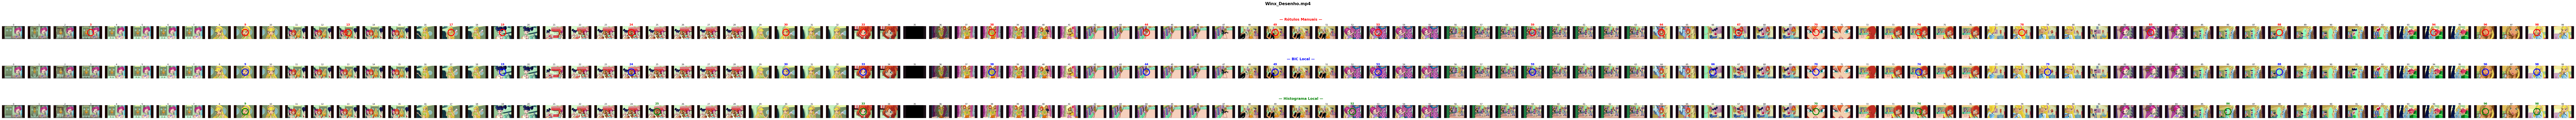

In [43]:
# Visualização comparativa
plot_comparative_keyframes(frames, manual_keys, bic_keys, hist_keys, title=video["video_name"])


# Visualização dos frames de CORTE

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_comparative_cuts(frames, manual_cuts, bic_cuts, hist_cuts, title="Comparativo de Cortes de Cena"):
    """
    Mostra os cortes de cena detectados por cada método (Manual, BIC, Histograma),
    destacando ambos os frames do par [start, end] com círculos coloridos.
    """
    n = len(frames)
    fig, axes = plt.subplots(3, n, figsize=(n * 1.3, 6))
    fig.subplots_adjust(left=0.04, right=0.98, top=0.88, bottom=0.05, wspace=0.05, hspace=0.35)

    # Gera conjuntos de todos os índices de corte (start e end)
    manual_indices = {i for pair in manual_cuts for i in pair}
    bic_indices = {i for pair in bic_cuts for i in pair}
    hist_indices = {i for pair in hist_cuts for i in pair}

    cut_sets = [manual_indices, bic_indices, hist_indices]
    row_titles = ["Rótulos Manuais", "BIC Local", "Histograma Local"]
    row_colors = ["red", "blue", "green"]

    for r, (ax_row, cuts, row_title, color) in enumerate(zip(axes, cut_sets, row_titles, row_colors)):
        for c, ax in enumerate(ax_row):
            ax.imshow(frames[c])
            ax.axis("off")

            # Se o frame fizer parte de um par de corte → círculo colorido
            if c in cuts:
                h, w, _ = frames[c].shape
                ax.add_patch(plt.Circle((w/2, h/2), radius=h/4, color=color, fill=False, linewidth=3))
                ax.set_title(str(c), fontsize=10, color=color, fontweight="bold", pad=2)
            else:
                ax.set_title(str(c), fontsize=8, color="black", pad=2)

        # Adiciona legenda acima da linha
        axes[r, n//2].set_title(
            f"— {row_title} —",
            fontsize=13,
            color=color,
            fontweight="bold",
            pad=20
        )

    plt.suptitle(title, fontsize=15, fontweight="bold")
    plt.tight_layout()
    plt.show()


In [ ]:
plot_comparative_cuts(frames, manual, bic_cuts, hist_cuts, title=video["video_name"])
